# Context-Aware Saliency Detection
http://ieeexplore.ieee.org/document/6112774/   
http://roman-kh.github.io/numpy-multicore/  
https://github.com/pydata/numexpr

In [58]:
import os
import time
import subprocess
import cv2
import numpy as np
import matplotlib.pylab as plt
from scipy import signal
%matplotlib inline

In [59]:
def img2lab(img_path):
    bgr_img = cv2.imread(img_path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return cv2.cvtColor(rgb_img, cv2.COLOR_BGR2LAB)

In [60]:
def pad_img(img, kernel_size, padding):
    '''input: img: a NumPy array, get from function img2lab
              kernel_size: an int number, maybe 3*3 or 5*5 or 7*7 etc. 7*7 in paper
              padding: the ways of padding
       output:img: a image after padding
    '''
    size = (kernel_size - 1) / 2
    if padding == 'replicate':
        img_pad = cv2.copyMakeBorder(img, size, size, size, size, cv2.BORDER_REPLICATE)
    elif padding == 'constant':
        WHITE = [0, 0, 0]
        img_pad = cv2.copyMakeBorder(img, size, size, size, size, cv2.BORDER_CONSTANT, value=WHITE)
    return img_pad

# Get pixel patches in vectorize way
https://stackoverflow.com/questions/30109068/implement-matlabs-im2col-sliding-in-python

In [61]:
def pixel_patch_vectorize(img_pad, kernel_size, stride):
    H, W, C = img_pad.shape
    s0, s1, s2 = img_pad.strides
    nH = H - kernel_size + 1
    nW = W - kernel_size + 1
    # In there kernel size is a square in all 3 channels
    # Actually, the size of kernel is  kernel_size*kernel_size*3
    nC = C - 3 + 1
    
    shp = kernel_size, kernel_size, C, nH, nW, nC
    strd = s0, s1, s2, s0, s1, s2
    out_view = np.lib.stride_tricks.as_strided(img_pad, shape=shp, strides=strd)
    img_patch_full = out_view.reshape(kernel_size*kernel_size*C, nH, nW).transpose(1,2,0)
    H_idx = np.array(range(0, nH, stride)).reshape(-1,1)
    W_idx = np.array(range(0, nW, stride)).reshape(1,-1)
    return img_patch_full[H_idx, W_idx]

# Get pixel patches in naive way

In [62]:
def pixel_patch(img_pad, kernel_size, stride):
    # stride: In paper, it has 50% overlap, so stride is 3 according kernel_size is 7.
    # shape of img_pad : [H, W, C]
    H_pad, W_pad, C = img_pad.shape
    
    # the resolution of image after patch
    H = (H_pad - kernel_size)/ stride + 1
    W = (W_pad - kernel_size)/ stride + 1
    
    img_patch = np.zeros((H, W, C*kernel_size**2))
    
    for i in range(H):
        for j in range(W):
            img_patch[i, j] = img_pad[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size].reshape(-1)
    return img_patch

# Get saliency map in vectorize way

In [63]:
def get_saliency_value_vectorize(img_patch, C, K):
    # C: the weight multiply by positional distance
    # K: the top K similar distances with other pixel patches for each pixel
    H, W, C = img_patch.shape
    # save the saliency value
    s = np.zeros((H, W))

    # get matrix's shape A:(H,W,H,W,kernel_size*kernel_size*C)
    # A[i,j,:,:,:] is img_patch
    A = np.tile(img_patch, (H,W,1)).reshape(H,H,W,W,C).transpose(0,2,1,3,4)

    # get matrix's shape B:(H,W,H,W,kernel_size*kernel_size*C)
    # B[i,j,:,:,:] is img_patch[i,j,:]
    B = np.repeat(img_patch, H, axis=0)
    B = np.repeat(B, W, axis=1).reshape(H,H,W,W,C).transpose(0,2,1,3,4)

    # calculate the color distances for all pixels with other
    d_col = np.sqrt(np.sum((A - B)**2, axis=4))
    # normlized to [0,1]
    d_col_norm = (d_col - d_col.min((2,3))) / (d_col.max((2,3)) - d_col.min((2,3)))
    
    # find K most similar patches according to d_col value
    
      # add a very small perturbation, avoid too many value equal to 0
    d_col_norm_flat = d_col_norm.reshape(H*W, -1) + 0.0000001*np.random.rand(H*W, H*W)
    # get the Kth value for each pixel
    Kth = d_col_norm_flat[range(H*W), np.argpartition(d_col_norm_flat,K)[:, K:K+1].reshape(-1)].reshape(-1,1)
      # shape (H*W*K, 2)   
    Kth_idx = np.argwhere(d_col_norm_flat < Kth)

      # shape (H*W, K)
    d_col_K = d_col_norm_flat[Kth_idx[:,0], Kth_idx[:,1]].reshape(H*W, -1)
    
    # calculate positional distance for all pixels of the top K
      # shape (H*W, K)
    Kth_x_idx = Kth_idx[:,1].reshape(H*W, -1) / W
    Kth_y_idx = Kth_idx[:,1].reshape(H*W, -1) % W
      # pixel idx, shape(H*W, 1)
    pixel_x_idx = np.repeat(np.array(range(H)), W)
    pixel_y_idx = np.tile(np.array(range(W)), H)

    d_pos = np.sqrt((Kth_x_idx - pixel_x_idx.reshape(-1,1))**2 + (Kth_y_idx - pixel_y_idx.reshape(-1,1))**2)
    # normalized by the larger image dimension
    d_pos_norm = d_pos / max(H,W)
    
    # single-scale saliency value map of a image at scale r
    dis_K = d_col_K / (1 + C*d_pos_norm)
    s_flat = 1 -  np.exp(-1.0/K * np.sum(dis_K, axis=1))
    s = s_flat.reshape(H, W)
    
    # # normalized to [0, 1]
    s_norm = (s - s.min()) / (s.max() - s.min())
    return s_norm

# Get saliency map in naive way

In [64]:
def get_saliency_value(img_patch, C, K):
    # C: the weight multiply by positional distance
    # K: the top K similar distances with other pixel patches for each pixel
    H, W, _ = img_patch.shape
    # save the saliency value
    s = np.zeros((H, W))
    
    for i in range(H):
        for j in range(W):

            # calculate the color distance for each pixel
            d_col = np.sqrt(np.sum((img_patch - img_patch[i,j])**2, axis=2))
            #normlized to [0,1]
            d_col_norm = (d_col -  d_col.min()) / (d_col.max() - d_col.min())
            
            # find K most similar patches according to d_col value
            d_col_norm_flat = d_col_norm.reshape(-1)
            Kth = d_col_norm_flat[np.argpartition(d_col_norm_flat,K)[K:K+1]]
            Kth_idx = np.argwhere(d_col_norm < Kth)
            
            # calculate positional distance for each pixel of the top K
            local_pos = np.array([i,j])
            d_pos = np.sqrt(np.sum((Kth_idx - local_pos)**2, axis=1))
            # normalized by the larger image dimension
            d_pos_norm = d_pos / max(H,W)
            
            # single-scale saliency value map of a image at scale r
            dis_K = d_col_norm[Kth_idx[:,0], Kth_idx[:,1]] / (1.0 + C*d_pos)
            s[i,j] = 1 -  np.exp(-1.0/K * np.sum(dis_K))
    # normalized to [0, 1]
    s_norm = (s - s.min()) / (s.max() - s.min())
    return s_norm

# Add contextual effect in vectorize way

In [65]:
def contextual_effect_vectorize(sal_map, threshold):
    # threshold: Threshold is 0.8 in paper.
    H, W = sal_map.shape
    s_attended_idx = np.argwhere(sal_map>threshold)
    
      # pixel idx, shape(H*W, 2)
    pixel_x_idx = np.repeat(np.array(range(H)), W)
    pixel_y_idx = np.tile(np.array(range(W)), H)
    
    d_foci = np.sqrt((pixel_x_idx.reshape(-1,1) - s_attended_idx[:,0].reshape(1,-1))**2+
                            (pixel_y_idx.reshape(-1,1) - s_attended_idx[:,1].reshape(1,-1))**2)
    d_foci = d_foci.min(axis=1).reshape(H, W)
    
    # normalized to the range [0,1]
    d_foci_norm = (d_foci - d_foci.min()) / (d_foci.max() - d_foci.min())
    # Apply to saliency map
    sal_cont_map = sal_map * (1 - d_foci_norm)
    return sal_cont_map

# Add contextual effect in naive way

In [66]:
def contextual_effect(sal_map, threshold):
    # threshold: Threshold is 0.8 in paper.
    H, W = sal_map.shape
    s_attended_idx = np.argwhere(sal_map>threshold)
    # init the output
    d_foci = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            # calculate the positional distance for each pixel
            local_pos = np.array([i,j])
            d_pos = np.sqrt(np.sum((s_attended_idx - local_pos)**2, axis=1))
            d_foci[i, j] = np.min(d_pos)
    # normalized to the range [0,1]
    d_foci_norm = (d_foci - d_foci.min()) / (d_foci.max() - d_foci.min())
    # Apply to saliency map
    sal_cont_map = sal_map * (1 - d_foci_norm)
    return sal_cont_map

# vectorize way

In [67]:
def multiscale_vectorize(img_path, img_scales, kernel_size, stride, C, K, threshold, padding):
    # img_scales: a list, the rates of shrink a image. In paper, it is [1, 0.8, 0.5, 0.3]
    # get image in LAB type
    img = img2lab(img_path)
    H_org, W_org, _ = img.shape
    rate = H_org*1.0 / W_org

    # resize the resolution of image, the maximum is 250    
    if H_org > W_org and H_org > 250:
        H = 250
        W = int(H / rate)
    elif W_org > H_org and W_org > 250:
        W = 250
        H = int(W*rate)
    else:
        W, H = W_org, H_org
    
    img = cv2.resize(img, (W, H))
    H, W, _ = img.shape
    # multi-scale saliency value
    N = len(img_scales)
    s = np.zeros((H, W, N))
    
    for i, scale_rate in enumerate(img_scales):
        # shrink image at a scale_rate
        img_scale = cv2.resize(img, (int(W*scale_rate), int(H*scale_rate)))
        
        # for each kernel size, do padding
        img_pad = pad_img(img_scale, kernel_size, padding)
        
        # get patch matrix for each pixel in image
        img_patch_verc = pixel_patch_vectorize(img_pad, kernel_size, stride)

        # get saliency value for a image scale
        sal_map = get_saliency_value_vectorize(img_patch_verc, C, K)
    
        # Interpolated back to original image size, default value is bilinear interpolation.
        sal_map_rescale = cv2.resize(sal_map, (W, H))
        
        # Immediate Context
#         sal_cont_map = contextual_effect(sal_map_rescale, threshold)
        sal_cont_map = contextual_effect_vectorize(sal_map_rescale, threshold)
    
        s[:,:,i] = sal_cont_map
    s_aver = 1.0/N * np.sum(s, axis = 2)
    return s_aver

# naive way

In [79]:
def multiscale(img_path, img_scales, kernel_size, stride, C, K, threshold, padding):
    # img_scales: a list, the rates of shrink a image. In paper, it is [1, 0.8, 0.5, 0.3]
    # get image in LAB type
    img = img2lab(img_path)
    H_org, W_org, _ = img.shape
    rate = H_org*1.0 / W_org
    
    # resize the resolution of image, the maximum is 250    
    if H_org > W_org and H_org > 250:
        H = 250
        W = int(H / rate)
    elif W_org > H_org and W_org > 250:
        W = 250
        H = int(W*rate)
    else:
        W, H = W_org, H_org
    
    img = cv2.resize(img, (W, H))
    H, W, _ = img.shape
    # multi-scale saliency value
    N = len(img_scales)
    s = np.zeros((H, W, N))
    
    for i, scale_rate in enumerate(img_scales):
        # shrink image at a scale_rate
        img_scale = cv2.resize(img, (int(W*scale_rate), int(H*scale_rate)))
        
        # for each kernel size, do padding
        img_pad = pad_img(img_scale, kernel_size, padding)
        
        # get patch matrix for each pixel in image
        img_patch = pixel_patch(img_pad, kernel_size, stride)

        # get saliency value for a image scale
        sal_map = get_saliency_value(img_patch, C, K)
    
        # Interpolated back to original image size, default value is bilinear interpolation.
        sal_map_rescale = cv2.resize(sal_map, (W, H))
        
        # Immediate Context
        sal_cont_map = contextual_effect(sal_map_rescale, threshold)

        s[:,:,i] = sal_cont_map
    s_aver = 1.0/N * np.sum(s, axis = 2)
    return s_aver

In [69]:
def center_prior(s):
    from scipy import signal
    H, W = s.shape
    H_std = H*1.0/6
    W_std = W*1.0/6
    gH = signal.gaussian(H, std = H_std).reshape(H, 1)
    gW = signal.gaussian(W, std = W_std).reshape(W, 1)
    g2d = np.outer(gH, gW)
    return g2d*s
#     print g2d.shape
#     plt.imshow(g2d, cmap='gray')
#     plt.axis("off")
#     plt.show()

In [85]:
def main():
    print 'stride is 3 with vectorize'
    PATH = './hw2_test_images'
    print 'Check image files'
    print subprocess.check_output(["ls", PATH]).decode('utf8')
    all_imgs = os.listdir(PATH)
    for img in all_imgs:
        if img == '.ipynb_checkpoints':
            continue
        img_path = os.path.join(PATH, img)
        print img_path

        kernel_size = 7
        img_scales = [1, 0.8, 0.5, 0.3]
        # img_scales = [1]
        threshold = 0.8
        C = 3
        K = 65
        stride = 3
        padding = 'replicate'
        start  = time.time()
        saliency_map = multiscale_vectorize(img_path, 
                                            img_scales, 
                                            kernel_size, 
                                            stride, 
                                            C, 
                                            K, 
                                            threshold, 
                                            padding)
        end = time.time()
        print 'Running time is: '+str(end-start)
        s = center_prior(saliency_map)
        
        # show original image
        bgr_img = cv2.imread(img_path)
        rgb_img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.axis("off")
        plt.show()
        # show saliency map
        plt.imshow(saliency_map, cmap='gray')
        plt.axis("off")
        plt.show()
        # show saliency map with center prior
        plt.imshow(s, cmap='gray')
        plt.axis("off")
        plt.show()
#         cv2.imwrite(PATH+'/saliency'+img, saliency_map)

Check image files
1.jpg
2.jpg
3.jpg
bird.jpg

./hw2_test_images/1.jpg
Running time is: 22.2639198303


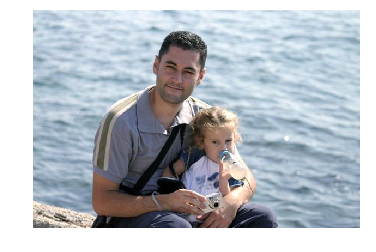

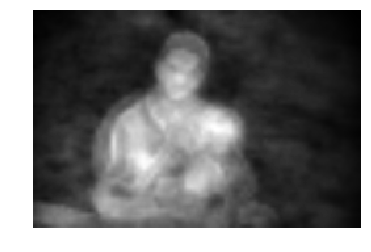

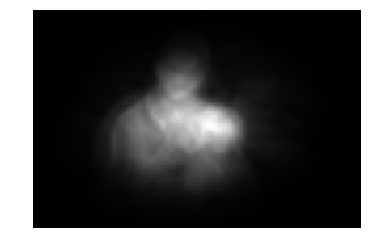

./hw2_test_images/bird.jpg
Running time is: 44.3611228466


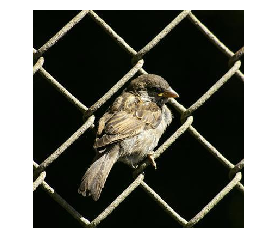

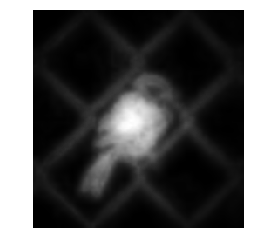

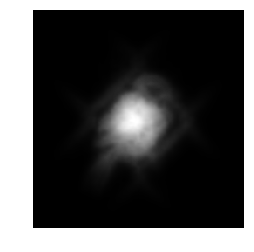

./hw2_test_images/2.jpg
Running time is: 15.33253479


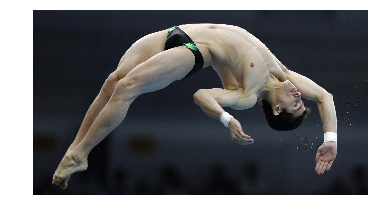

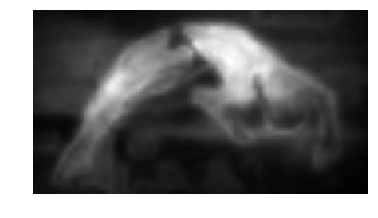

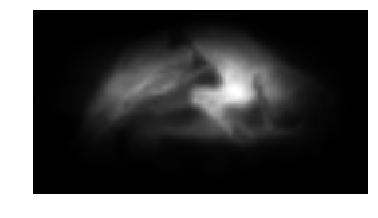

./hw2_test_images/3.jpg
Running time is: 27.456401825


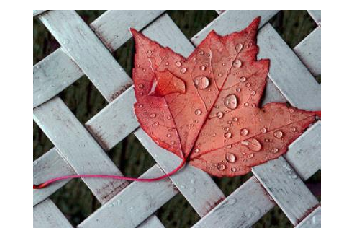

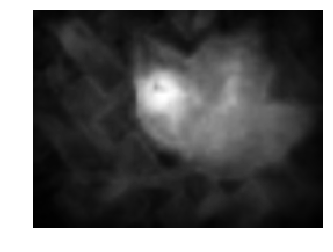

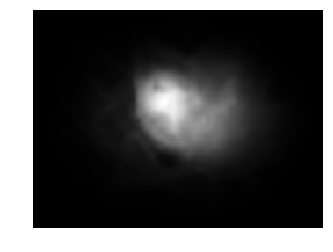

In [74]:
if __name__ == '__main__':
    main()

In [86]:
def main():
    print 'stride is 3'
    PATH = './hw2_test_images'
    print 'Check image files'
    print subprocess.check_output(["ls", PATH]).decode('utf8')
    all_imgs = os.listdir(PATH)
    for img in all_imgs:
        if img == '.ipynb_checkpoints':
            continue
        img_path = os.path.join(PATH, img)
        print img_path

        kernel_size = 7
        img_scales = [1, 0.8, 0.5, 0.3]
        # img_scales = [1]
        threshold = 0.8
        C = 3
        K = 65
        stride = 3
        padding = 'replicate'
        start  = time.time()
        saliency_map = multiscale(img_path, 
                                  img_scales, 
                                  kernel_size, 
                                  stride, 
                                  C, 
                                  K, 
                                  threshold, 
                                  padding)
        end = time.time()
        print 'Running time is: '+str(end-start)
        s = center_prior(saliency_map)
        
        # show original image
        bgr_img = cv2.imread(img_path)
        rgb_img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.axis("off")
        plt.show()
        # show saliency map
        plt.imshow(saliency_map, cmap='gray')
        plt.axis("off")
        plt.show()
        # show saliency map with center prior
        plt.imshow(s, cmap='gray')
        plt.axis("off")
        plt.show()
#         cv2.imwrite(PATH+'/saliency'+img, saliency_map)

stride is 3
Check image files
1.jpg
2.jpg
3.jpg
bird.jpg

./hw2_test_images/1.jpg
Running time is: 12.8547151089


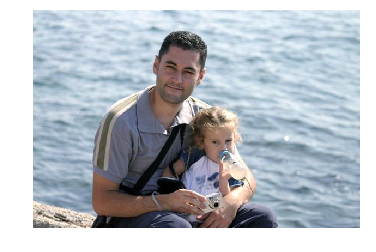

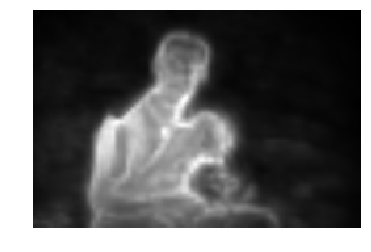

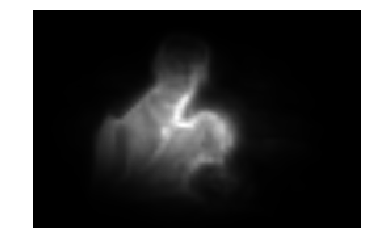

./hw2_test_images/bird.jpg
Running time is: 26.7633290291


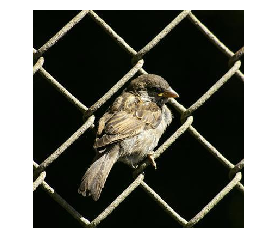

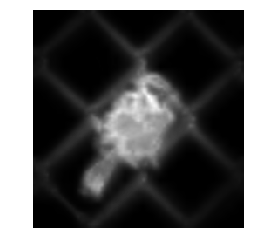

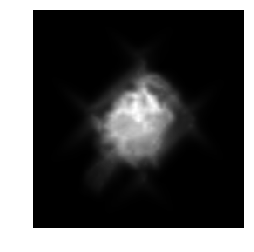

./hw2_test_images/2.jpg
Running time is: 9.70888209343


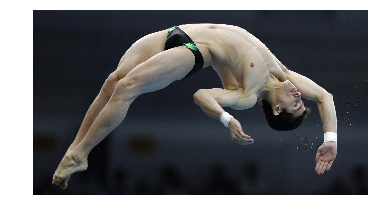

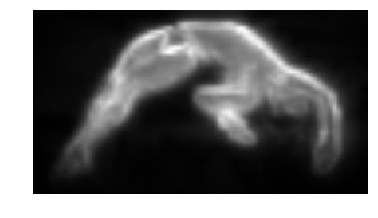

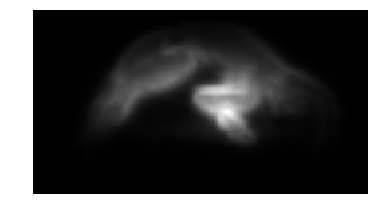

./hw2_test_images/3.jpg
Running time is: 15.9657449722


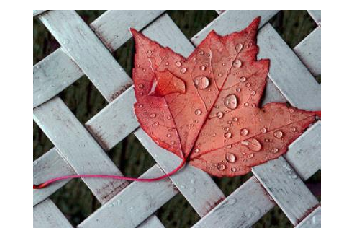

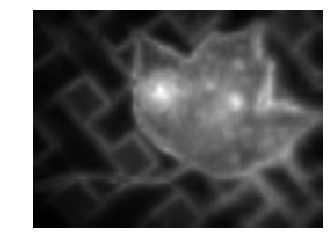

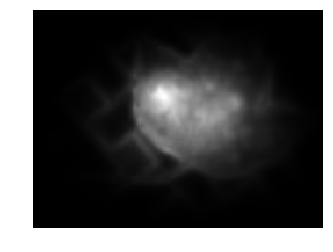

In [87]:
if __name__ == '__main__':
    main()

# stride = 2

In [88]:
def main():
    print 'stride is 2'
    PATH = './hw2_test_images'
    print 'Check image files'
    print subprocess.check_output(["ls", PATH]).decode('utf8')
    all_imgs = os.listdir(PATH)
    for img in all_imgs:
        if img == '.ipynb_checkpoints':
            continue
        img_path = os.path.join(PATH, img)
        print img_path

        kernel_size = 7
        img_scales = [1, 0.8, 0.5, 0.3]
        # img_scales = [1]
        threshold = 0.8
        C = 3
        K = 65
        stride = 2
        padding = 'replicate'
        start  = time.time()
        saliency_map = multiscale(img_path, 
                                  img_scales, 
                                  kernel_size, 
                                  stride, 
                                  C, 
                                  K, 
                                  threshold, 
                                  padding)
        end = time.time()
        print 'Running time is: '+str(end-start)
        s = center_prior(saliency_map)
        
        # show original image
        bgr_img = cv2.imread(img_path)
        rgb_img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.axis("off")
        plt.show()
        # show saliency map
        plt.imshow(saliency_map, cmap='gray')
        plt.axis("off")
        plt.show()
        # show saliency map with center prior
        plt.imshow(s, cmap='gray')
        plt.axis("off")
        plt.show()
#         cv2.imwrite(PATH+'/saliency'+img, saliency_map)

stride is 2
Check image files
1.jpg
2.jpg
3.jpg
bird.jpg

./hw2_test_images/1.jpg
Running time is: 60.2886710167


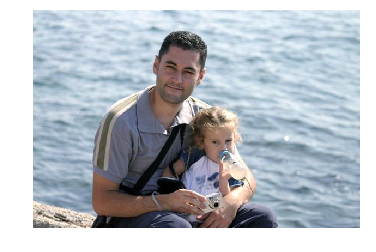

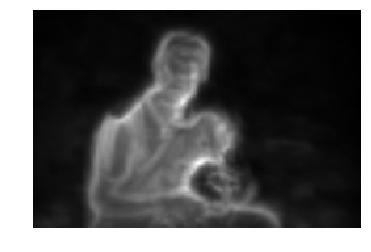

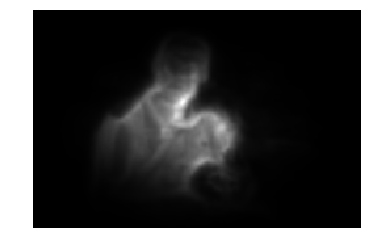

./hw2_test_images/bird.jpg
Running time is: 152.672214985


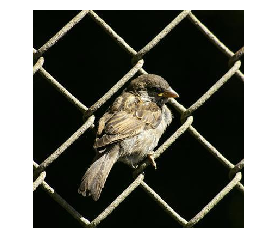

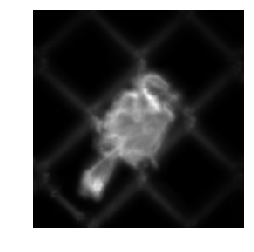

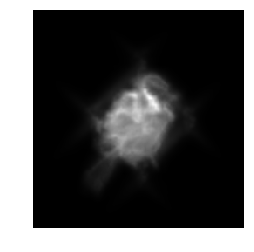

./hw2_test_images/2.jpg
Running time is: 39.4885730743


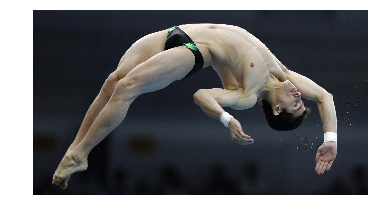

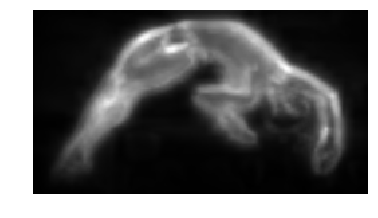

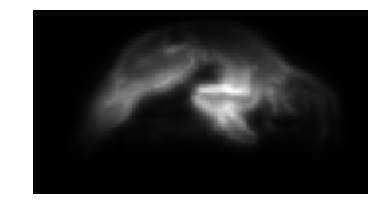

./hw2_test_images/3.jpg
Running time is: 81.1783180237


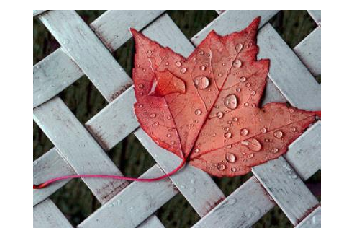

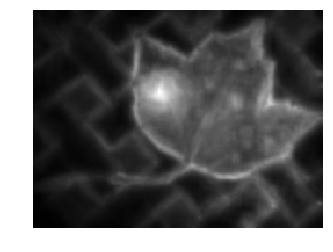

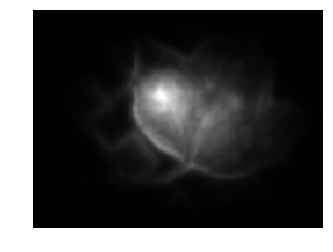

In [89]:
if __name__ == '__main__':
    main()

# 下面是草稿

In [216]:
PATH = './hw2_test_images'
print 'Check image files'
print subprocess.check_output(["ls", PATH]).decode('utf8')
all_imgs = os.listdir(PATH)
for img in all_imgs:

    img_path = os.path.join(PATH, img)
    print img_path

Check image files
1.jpg
2.jpg
3.jpg
bird.jpg

./hw2_test_images/1.jpg
./hw2_test_images/bird.jpg
./hw2_test_images/2.jpg
./hw2_test_images/3.jpg


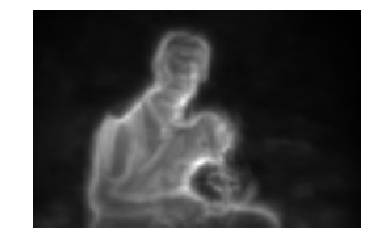

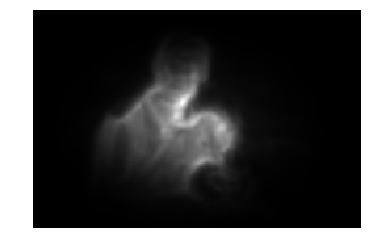

In [213]:
plt.imshow(saliency_map, cmap='gray')
plt.axis("off")
plt.show()
s_prime = center_prior(saliency_map)
plt.imshow(s_prime, cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
print saliency_map

In [71]:
PATH = './hw2_test_images/'
img_path = PATH + '1.jpg'
kernel_size = 7
C = 3
K = 65
padding = 'replicate'
# get image in LAB type
img_scales = [1]
threshold = 0.8
stride = 3
img = img2lab(img_path)
print img.shape

(400, 600, 3)


In [73]:
img_pad = pad_img(img, kernel_size, padding)
print img_pad.shape

(406, 606, 3)


In [76]:
def pixel_patch_vectorize(img_pad, kernel_size, stride):
    H, W, C = img_pad.shape
    s0, s1, s2 = img_pad.strides
    nH = H - kernel_size + 1
    nW = W - kernel_size + 1
    # In there kernel size is a square in all 3 channels
    # Actually, the size of kernel is  kernel_size*kernel_size*3
    nC = C - 3 + 1
    
    shp = kernel_size, kernel_size, C, nH, nW, nC
    strd = s0, s1, s2, s0, s1, s2
    out_view = np.lib.stride_tricks.as_strided(img_pad, shape=shp, strides=strd)
    img_patch_full = out_view.reshape(kernel_size*kernel_size*C, nH, nW).transpose(1,2,0)
    H_idx = np.array(range(0,nH,stride)).reshape(-1,1)
    W_idx = np.array(range(0,nW,stride)).reshape(1,-1)
    print H_idx[-10:]
    print W_idx[:,-10]
    return img_patch_full[H_idx, W_idx]
img_patch = pixel_patch_vectorize(img_pad, kernel_size, stride)
print img_patch.shape

[[372]
 [375]
 [378]
 [381]
 [384]
 [387]
 [390]
 [393]
 [396]
 [399]]
[570]
(134, 200, 147)


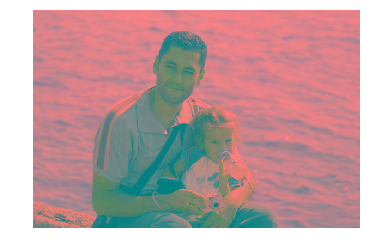

In [153]:
plt.imshow(img)
plt.axis("off")
plt.show()

(166, 250, 3) (166, 250, 1)


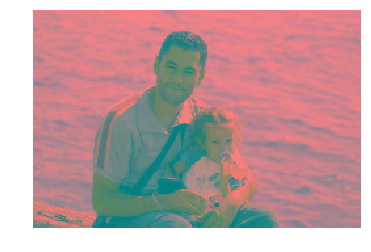

In [154]:
H_org, W_org, _ = img.shape
rate = H_org*1.0 / W_org
#     temp_max = max(H_org, W_org)
#     temp_min = min(H_org, W_org)
#     rate = temp_max*1.0 / temp_min
#     if temp_max > 250:
# resize the resolution of image, the maximum is 250    
if H_org > W_org and H_org > 250:
    H = 250
    W = int(H / rate)
elif W_org > H_org and W_org > 250:
    W = 250
    H = int(W*rate)

img = cv2.resize(img, (W, H))
H, W, _ = img.shape
# multi-scale saliency value
N = len(img_scales)
s = np.zeros((H, W, N))
print img.shape, s.shape
plt.imshow(img)
plt.axis("off")
plt.show()

(166, 250, 3)


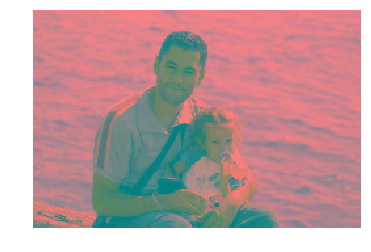

In [156]:
scale_rate = 1
# shrink image at a scale_rate
img_scale = cv2.resize(img, (int(W*scale_rate), int(H*scale_rate)))
print img_scale.shape
plt.imshow(img_scale)
plt.axis("off")
plt.show()

In [72]:
# for each kernel size, do padding
img_pad = pad_img(img_scale, kernel_size, padding)
print img_pad.shape

plt.imshow(img_scale)
plt.axis("off")
plt.show()

NameError: name 'img_scale' is not defined

In [160]:
# get patch matrix for each pixel in image
img_patch = pixel_patch(img_pad, kernel_size, stride)

print img_patch.shape
print img_patch[2,1] - img_pad[4:11, 2:9, :].reshape(-1)

(83, 125, 147)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


i : 0
i : 1
i : 2
i : 3
i : 4
i : 5
i : 6
i : 7
i : 8
i : 9
i : 10
i : 11
i : 12
i : 13
i : 14
i : 15
i : 16
i : 17
i : 18
i : 19
i : 20
i : 21
i : 22
i : 23
i : 24
i : 25
i : 26
i : 27
i : 28
i : 29
i : 30
i : 31
i : 32
i : 33
i : 34
i : 35
i : 36
i : 37
i : 38
i : 39
i : 40
i : 41
i : 42
i : 43
i : 44
i : 45
i : 46
i : 47
i : 48
i : 49
i : 50
i : 51
i : 52
i : 53
i : 54
i : 55
i : 56
i : 57
i : 58
i : 59
i : 60
i : 61
i : 62
i : 63
i : 64
i : 65
i : 66
i : 67
i : 68
i : 69
i : 70
i : 71
i : 72
i : 73
i : 74
i : 75
i : 76
i : 77
i : 78
i : 79
i : 80
i : 81
i : 82
(83, 125)


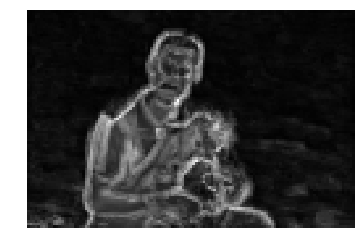

In [167]:
# get saliency value for a image scale
sal_map = get_saliency_value(img_patch, C, K)

print sal_map.shape
plt.imshow(sal_map, cmap='gray')
plt.axis("off")
plt.show()

(166, 250)


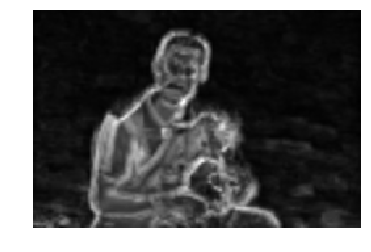

[[ 67 116]
 [ 68 114]
 [ 68 115]
 [ 68 116]
 [ 69 113]
 [ 69 114]
 [ 69 115]
 [ 70 112]
 [ 70 113]
 [ 70 114]
 [ 70 115]
 [ 71 112]
 [ 71 113]
 [ 71 114]
 [ 71 115]
 [ 72 112]
 [ 72 113]
 [ 80  70]
 [ 80  71]
 [ 80  72]
 [ 81  70]
 [ 81  71]
 [ 82  68]
 [ 82  69]
 [ 83  67]
 [ 83  68]
 [ 83  69]
 [ 84  61]
 [ 84  62]
 [ 84  63]
 [ 85  61]
 [ 85  62]
 [ 85  63]
 [ 85  64]
 [ 86  60]
 [ 86  61]
 [ 86  62]
 [ 86  63]
 [ 87  60]
 [ 87  61]
 [ 87  62]
 [ 87 143]
 [ 87 144]
 [ 87 145]
 [ 88  61]
 [ 88 143]
 [ 88 144]
 [ 88 145]
 [ 89 143]
 [ 89 144]
 [ 89 145]
 [ 90 143]
 [ 90 144]
 [ 91  99]
 [113 127]
 [113 128]
 [113 129]
 [114 126]
 [114 127]
 [114 128]
 [114 129]
 [115 125]
 [115 126]
 [115 127]
 [115 128]
 [115 129]
 [116 124]
 [116 125]
 [116 126]
 [116 127]
 [117 123]
 [117 124]
 [117 125]
 [117 126]
 [118 123]
 [118 124]
 [150 160]]


In [175]:
N = 1
# Interpolated back to original image size, default value is bilinear interpolation.
sal_map_rescale = cv2.resize(sal_map, (W, H))


print sal_map_rescale.shape
plt.imshow(sal_map_rescale, cmap='gray')
plt.axis("off")
plt.show()
print np.argwhere(sal_map_rescale>0.7)

(166, 250)


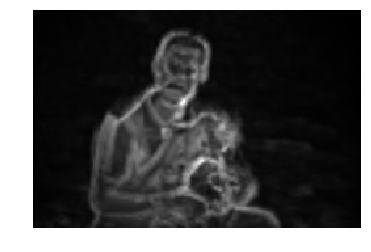

In [179]:
# Immediate Context
sal_cont_map_norm = contextual_effect(sal_map_rescale, threshold)

print sal_cont_map_norm.shape
plt.imshow(sal_cont_map_norm, cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
# Interpolated back to original image size, default value is bilinear interpolation.
s[:,:,i] = cv2.resize(sal_cont_map_norm, (W, H))
s_aver = 1.0/N * np.sum(s, axis = 2)

(166, 250)


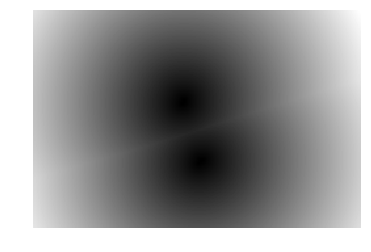

In [171]:
print s_aver.shape
plt.imshow(s_aver, cmap='gray')
plt.axis("off")
plt.show()

In [65]:
img = cv2.resize(img, (150, 100))

In [66]:
kernel_size = 7
img_pad = pad_img(img, kernel_size, padding)
print img_pad.shape

(106, 156, 3)


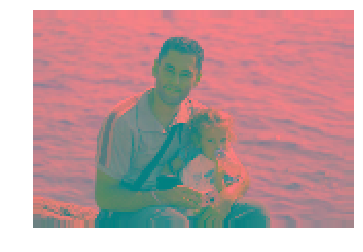

In [67]:
plt.imshow(img_pad)
plt.axis("off")
plt.show()

In [68]:
img_patch = pixel_patch(img_pad, kernel_size)
print img_patch.shape

(100, 150, 147)


In [49]:
# check
print np.sum(img_pad[0:7,1:8,:].reshape(1,-1) - img_patch[0,1])

0.0


In [69]:
s = get_saliency_value(img_patch, C, K)
print s.shape

i : 0
i : 1
i : 2
i : 3
i : 4
i : 5
i : 6
i : 7
i : 8
i : 9
i : 10
i : 11
i : 12
i : 13
i : 14
i : 15
i : 16
i : 17
i : 18
i : 19
i : 20
i : 21
i : 22
i : 23
i : 24
i : 25
i : 26
i : 27
i : 28
i : 29
i : 30
i : 31
i : 32
i : 33
i : 34
i : 35
i : 36
i : 37
i : 38
i : 39
i : 40
i : 41
i : 42
i : 43
i : 44
i : 45
i : 46
i : 47
i : 48
i : 49
i : 50
i : 51
i : 52
i : 53
i : 54
i : 55
i : 56
i : 57
i : 58
i : 59
i : 60
i : 61
i : 62
i : 63
i : 64
i : 65
i : 66
i : 67
i : 68
i : 69
i : 70
i : 71
i : 72
i : 73
i : 74
i : 75
i : 76
i : 77
i : 78
i : 79
i : 80
i : 81
i : 82
i : 83
i : 84
i : 85
i : 86
i : 87
i : 88
i : 89
i : 90
i : 91
i : 92
i : 93
i : 94
i : 95
i : 96
i : 97
i : 98
i : 99
(100, 150)


In [71]:
print s

[[0.99818751 0.99852501 0.99861734 ... 0.99784224 0.99747043 0.99672269]
 [0.99895771 0.99921746 0.99928206 ... 0.99934942 0.99923043 0.99891736]
 [0.99952086 0.99967194 0.999718   ... 0.99982773 0.99980347 0.99970914]
 ...
 [1.         1.         1.         ... 0.99999519 0.99999343 0.9999843 ]
 [1.         1.         1.         ... 0.99998804 0.99998491 0.99996929]
 [1.         1.         1.         ... 0.99991662 0.9998822  0.99979104]]


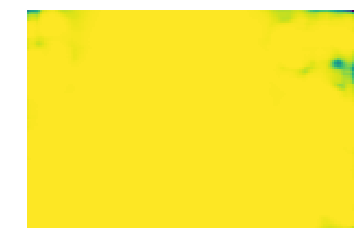

In [70]:
plt.imshow(s)
plt.axis("off")
plt.show()

In [24]:
print img[100,:]

[[174 129 142]
 [162 129 143]
 [151 131 143]
 [147 133 143]
 [152 132 143]
 [163 130 142]
 [166 129 142]
 [160 131 140]
 [160 131 140]
 [165 131 140]
 [167 131 141]
 [162 131 141]
 [158 131 141]
 [157 131 141]
 [160 129 141]
 [162 129 142]
 [159 129 141]
 [160 130 141]
 [164 129 141]
 [167 129 141]
 [173 129 142]
 [188 129 138]
 [194 130 141]
 [140 129 125]
 [ 97 134 101]
 [ 99 132 101]
 [100 134 101]
 [ 98 136 102]
 [ 97 132 102]
 [ 93 132 104]
 [ 88 136 110]
 [ 97 137 124]
 [ 98 135 128]
 [ 92 135 130]
 [ 73 129 132]
 [ 54 133 132]
 [ 42 134 133]
 [ 66 133 133]
 [ 73 135 134]
 [ 72 137 135]
 [ 57 134 135]
 [  4 129 128]
 [  8 127 129]
 [  6 128 129]
 [  7 127 130]
 [ 71 135 134]
 [ 85 141 137]
 [ 81 140 138]
 [ 43 135 137]
 [  5 128 130]
 [  3 128 128]
 [  3 129 129]
 [  7 129 129]
 [ 10 128 129]
 [ 11 129 129]
 [ 17 130 133]
 [ 19 132 131]
 [ 19 131 130]
 [ 65 138 136]
 [128 143 138]
 [174 142 140]
 [172 142 142]
 [174 140 139]
 [173 138 138]
 [145 139 142]
 [144 140 141]
 [131 140 

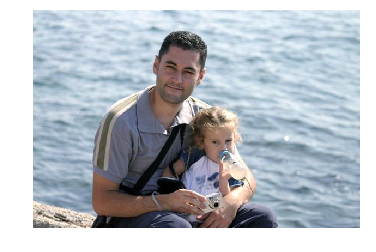

In [29]:
bgr_img = cv2.imread(img_path)
b,g,r = cv2.split(bgr_img)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.axis("off")
plt.show()

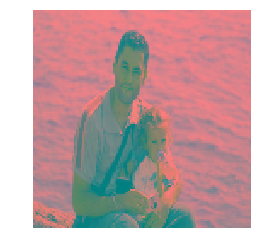

In [32]:
lab_img = img2lab(img_path)
img_resize = cv2.resize(lab_img, (128, 128))
plt.imshow(img_resize)
plt.axis("off")
plt.show()

In [55]:
H, W = 4, 5
temp = np.zeros((H, W))
idx_map = np.argwhere(temp==0).reshape(H, W, 2)
i, j = 0, 0
local_pos = np.array([i,j])
d_pos = np.sqrt(np.sum((idx_map - local_pos)**2, axis=2))
print d_pos

[[0.         1.         2.         3.         4.        ]
 [1.         1.41421356 2.23606798 3.16227766 4.12310563]
 [2.         2.23606798 2.82842712 3.60555128 4.47213595]
 [3.         3.16227766 3.60555128 4.24264069 5.        ]]


In [ ]:
H, W, _ = img.shape
# multi-scale saliency value
N = len(kernel_size_list)
s = np.zeros((H, W, N))

for i, kernel_size in enumerate(kernel_size_list):
    # for each kernel size, do padding
    img_pad = pad_img(img, kernel_size, padding)
    # get patch matrix for each pixel in image
    img_patch = pixel_patch(img_pad, kernel_size)
    # get saliency value for a kernel size
    s[:,:,i] = get_saliency_value(img_patch, C, K)
s_aver = 1.0/N * np.sum(s, axis = 2)
return s_aver

In [33]:
img_path = PATH + '1.jpg'
padding = 'replicate'
kernel_size = 5
img = img2lab(img_path)
print img.shape
img = pad_img(img, kernel_size, padding)
print img.shape

(400, 600, 3)
(404, 604, 3)


In [38]:
img_patch = pixel_patch(img, kernel_size)
print img_patch.shape

(400, 600, 75)


In [16]:
print H,W,C

404 604 3


In [17]:
size = 2
H, W = H - size*2, W - size*2

In [18]:
print H, W

400 600


In [27]:
a = img.reshape(-1)
print a.shape

(732048,)


In [32]:
a = np.array(range(60)).reshape(3,4,5)
print a.shape
b = np.array(range(5)).reshape(-1)
print b.shape
a[0,0] = b
print a.shape

(3, 4, 5)
(5,)
(3, 4, 5)


In [42]:
a = np.array(range(5)).reshape(1,-1)
b = np.array([a.T, a])
print a, b

[[0 1 2 3 4]] [array([[0],
       [1],
       [2],
       [3],
       [4]])
 array([[0, 1, 2, 3, 4]])]


In [44]:
a = np.array((range(5), range(5)))

In [45]:
print a

[[0 1 2 3 4]
 [0 1 2 3 4]]


In [73]:
a = np.zeros((5,5))
b = np.argwhere(a==0).reshape(5,5,2)
x = b - np.array([1,1])
print x[0,0], x[0,1], x[4,1]
print x, x.shape
print x.max(), x.min()

[-1 -1] [-1  0] [3 0]
[[[-1 -1]
  [-1  0]
  [-1  1]
  [-1  2]
  [-1  3]]

 [[ 0 -1]
  [ 0  0]
  [ 0  1]
  [ 0  2]
  [ 0  3]]

 [[ 1 -1]
  [ 1  0]
  [ 1  1]
  [ 1  2]
  [ 1  3]]

 [[ 2 -1]
  [ 2  0]
  [ 2  1]
  [ 2  2]
  [ 2  3]]

 [[ 3 -1]
  [ 3  0]
  [ 3  1]
  [ 3  2]
  [ 3  3]]] (5, 5, 2)
3 -1


In [56]:
K=4  
a = np.array([0, 8, 0, 4, 5, 8, 8, 0, 4, 2])  
b = a[np.argpartition(a,-K)[-K:]]
print b


[5 8 8 8]


In [101]:
a = np.array([[5,0,2,3],[1,4,2,3],[7,3,8,4]])
print a
# print a.argsort()[:4]
print np.minimum(a,1)

[[5 0 2 3]
 [1 4 2 3]
 [7 3 8 4]]
[[1 0 1 1]
 [1 1 1 1]
 [1 1 1 1]]


In [96]:
b = a.reshape(-1)
scala =  b[np.argpartition(b.reshape(-1),-4)[-4:-3]]
print scala
idx = np.argwhere(a>scala)
print idx, idx.shape

[4]
[[0 0]
 [2 0]
 [2 2]] (3, 2)


In [97]:
print a[idx[:,0].T, idx[:,1]]

[5 7 8]


In [98]:
print max(4,5)

5


(100, 2)


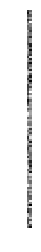

In [190]:
# mean = (0.5,0.5)
# cov = [[10,0],
a = np.random.multivariate_normal((0.5,0.5), [[np.sqrt(100.0/6),0],[0, np.sqrt(200.0/6)]], 100)
print a.shape
# b = np.sum(a, axis = 2)
plt.imshow(a, cmap='gray')
plt.axis("off")
plt.show()

In [105]:
a = np.random.normal(0.5, 100/6, 100)
print a

[  0.72850318  26.44312476 -12.42181045 -32.89748943 -21.6917575
   1.52462164  50.98991128  17.50774419 -27.16903242  18.94930346
 -22.45515638  -9.95751997   8.77834191 -16.45501356 -42.29425249
  10.06898031 -11.89373133  23.38697931  38.38321898  11.76973385
  -2.88287156 -10.17138559   4.13753159  14.16892162  -0.10026692
 -17.34392196   6.78982604   6.75082434 -15.38059135   6.25598154
  -6.14183473 -11.64125043  -2.4763351    7.50916517   1.10789074
  16.15054083   2.6267137   -5.80581906 -15.7882629    3.92830377
   0.507894     9.48928344  13.92351457 -38.31983436  15.5918201
 -19.72733666  -7.69879011 -12.95834104  14.89888425  -0.38014403
 -18.29500325  11.02942295  -5.53611963 -17.64704319  -7.83597672
  -0.097053   -13.60863984  23.8962093   25.04120553 -18.38808808
  -7.13906603  26.24877613  18.81128007  11.04152093  11.91283657
  -5.16752966  19.71294344  25.60348897   0.97770621  22.82627939
 -20.54576786  10.36158031  14.94419264  21.16517798 -22.28999605
   0.8964831

In [165]:
a = np.array([[5,0,2,3],[1,4,2,3],[7,3,8,4]]).reshape(-1)
b = a[np.argpartition(a,3)[:3]]
print b

[0 1 2]


In [194]:
H = 100
W = 200

H_axis = np.random.normal(loc=0.5, scale=np.sqrt(H*1.0/6), size=H)
W_axis = np.random.normal(loc=0.5, scale=np.sqrt(W*1.0/6), size=W)
print H_axis.shape, W_axis.shape

(100,) (200,)


(100, 200)


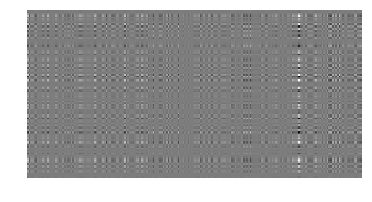

In [195]:
gauss2D = np.dot(H_axis.reshape(-1,1), W_axis.reshape(1,-1))
print gauss2D.shape
plt.imshow(gauss2D, cmap='gray')
plt.axis("off")
plt.show()

In [196]:
print H_axis

[-0.47577898 -1.44276518  3.53511316  8.09249685  0.45374441  3.58206706
  1.32423307 -2.62232904  7.50508536 -6.85161987 -5.72632317  5.43200726
 -4.97462696 -0.01045424 -3.36089116 -4.97563032  4.29613112 -0.67967436
 -0.35977777 -0.89053828 -2.18464546 -5.97910833 -0.01006984  0.24587671
  3.37122802  4.20800801 -4.96578248  0.65858802  2.82939808  6.19847578
  3.77674476 -2.03487138  5.85891974  5.83878442 -5.31374688  5.40294787
  1.78643665 -0.80135377  8.76783567 -8.54519292 -1.66122426  8.92459668
  4.14270428 -0.81515996 -0.653956    1.59643929  6.94762349 -3.25318152
 -4.58430847  1.91910339  1.66354073  3.92542268  1.31960933 -0.33286799
  4.57120872 -2.33607689  5.49930251  1.44674634  4.79979953 -1.57534016
 -1.22646735 -2.11844336  4.9145282   4.16332246 -8.41966624  1.78732354
  2.05260422 -2.95200953  2.60210102 -3.82682747 -5.06130204  3.22387048
 -7.4233146  -4.50994303  2.54926293  2.51252536  4.53606901  0.65217732
  7.98629797  5.28837786 -1.81726625 -4.4258014   2

(100, 200)


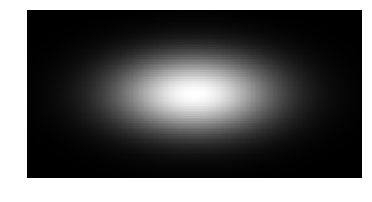

In [198]:
from scipy import signal
H = 100
W = 200
H_std = np.sqrt(H*1.0/6)
W_std = np.sqrt(W*1.0/6)
gH = signal.gaussian(H, std = 100/6).reshape(H, 1)
gW = signal.gaussian(W, std = 200/6).reshape(W, 1)
g2d = np.outer(gH, gW)
print g2d.shape
plt.imshow(g2d, cmap='gray')
plt.axis("off")
plt.show()

In [1]:
import numpy as np

In [2]:
a = np.array([[5,0,2,3],[1,4,2,3],[7,3,8,4]])
print a
b = a.reshape(-1)
scala =  b[np.argpartition(b.reshape(-1),-4)[-4:-3]]
print scala
idx = np.argwhere(a>scala)
print idx, idx.shape

[[5 0 2 3]
 [1 4 2 3]
 [7 3 8 4]]
[4]
[[0 0]
 [2 0]
 [2 2]] (3, 2)


In [3]:
print a[idx[:,0].T, idx[:,1]]
print a[idx[:,0].T.reshape(-1,1), idx[:,1].reshape(1,-1)]
print idx[:,0].shape

[5 7 8]
[[5 5 2]
 [7 7 8]
 [7 7 8]]
(3,)
